In [1]:
%matplotlib widget
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json
import uproot
from Utils import *
from matplotlib import ticker, cm
import succolib as sb
from matplotlib.ticker import LogFormatter 

In [2]:
config_file = r"./config.json"

with open(config_file, "r") as f:
            dizi = json.load(f)
dizi

{'RunAllignment': '600086',
 'd_12': 754,
 'd_23': 77,
 'd_2crist': 35,
 'd_1crist': 789,
 'd_13': 831,
 'd_tele1BC1': 949,
 'd_tele1BC2': 2033,
 'offset_x2': -0.5485682479826827,
 'offset_y2': 0.2032977623039198,
 'offset_x3': -0.15368590251347078,
 'offset_y3': 0.16081669777838922,
 'offset_x4': 6.060248038496313,
 'offset_y4': 6.468356939816961,
 'offset_x5': 7.473550546425691,
 'offset_y5': 3.7584738988484485,
 'div_12x': 2.487718339605658e-05,
 'div_12y': 4.195300645890466e-05,
 'div_13x': 2.5053823288893858e-05,
 'div_13y': 4.2227971758387904e-05,
 'div_BC1x': 2.6703885940950482e-05,
 'div_BC1y': -4.355999320197105e-05,
 'div_BC2x': 2.7839242544401937e-05,
 'div_BC2y': -4.3739289267343615e-05}

In [3]:
DictRun = {"600092":"x scan"}

In [4]:
runs=[600107] 
data_dir = "./ROOT"
pos =[]
infos=[]
for run in runs:
    data_path = f'{data_dir}/run{run}.root'

    with uproot.open(data_path) as root_file:
        # Stampa i nomi delle chiavi (TTree/TBranch) nel file root
        print(root_file.keys())
        key_names = root_file.keys()
        #root_file[key_names[0]].show()
        # Leggi i dati dalla chiave "xpos" e "xinfo" come array numpy
        xpos = np.array(root_file[key_names[0]]["xRaw"].array())
        xinfo = np.array(root_file[key_names[0]]["gonio"].array())

        # Aggiungi i dati alle liste pos e infos
        
        pos.append(xpos)
        infos.append(xinfo)

#print(np.shape(pos))
#print(np.shape(infos))
        
xpos = np.concatenate(pos,axis=0)
xinfo = np.concatenate(infos,axis=0)

#print(np.shape(xpos))
#print(np.shape(xinfo))

logic = (xpos > 0) & (xpos < 10)
logic2 = logic.all(axis = 1)
xpos = xpos[logic2]
xinfo = xinfo[logic2]


['t;1']


In [5]:
xpos[:,2] -= dizi['offset_x2']
xpos[:,3] -= dizi['offset_y2']
xpos[:,4] -= dizi['offset_x3']
xpos[:,5] -= dizi['offset_y3']
xpos[:,6] -= dizi['offset_x4']
xpos[:,7] -= dizi['offset_y4']
xpos[:,8] -= dizi['offset_x5']
xpos[:,9] -= dizi['offset_y5']

x1, y1 = xpos[:,0], xpos[:,1]
x2, y2 = xpos[:,2], xpos[:,3]
x3, y3 = xpos[:,4], xpos[:,5]
x4, y4 = xpos[:,6], xpos[:,7] # BC1
x5, y5 = xpos[:,8], xpos[:,9] # BC2

rot = xinfo[:,0]

def proiettaDistZ(z):
    mx = (x2-x1)/dizi["d_12"]
    xProj = x1 + mx * z
    
    my = (y2-y1)/dizi["d_12"]
    yProj = y1 + my * z
    
    return (xProj, yProj)
    
x_cry, y_cry = proiettaDistZ(dizi["d_12"]+dizi["d_2crist"])



In [6]:
###Si potrebbe fare un plot sulle correlazioni delle variabili, x1, x2; y1, y2; ...

### Definizione delle variabili



In [7]:
# definizione di theta x in
theta_in_x = np.arctan((x2-x1)/dizi['d_12']) * 1e6 # urad
theta_in_y = np.arctan((y2-y1)/dizi['d_12']) * 1e6 # urad

# theta out calcolato tra tele3 e BC1 ---> PER ANGOLI PICCOLI
d_3BC1 = dizi["d_tele1BC1"]-dizi["d_13"]

theta_out_x = np.arctan((x4-x3)/d_3BC1) * 1e6 # urad
theta_out_y = np.arctan((y3-y4)/d_3BC1) * 1e6 # urad

# theta out calcolato tra tele3 e BC2 ---> PER ANGOLI GRANDI
d_3BC2 = dizi["d_tele1BC2"]-dizi["d_13"]

theta_out_x2 = np.arctan((x4-x3)/d_3BC2) * 1e6 # urad
theta_out_y2 = np.arctan((y3-y4)/d_3BC2) * 1e6 # urad

#---------------------------------------------------------

thetain = [theta_in_x, theta_in_y]
thetaout = [theta_out_x, theta_out_y]
thetaout2 =[theta_out_x2, theta_out_y2]

### Plot istogrammi $\theta_{in}$, $\theta_{out}$, $\theta_{out2}$

(9,)
La divergenza in x vale 25.44 μrad

La divergenza in y vale 41.32 μrad

La divergenza in x vale 49.04 μrad

La divergenza in y vale -58.83 μrad

La divergenza in x vale -4.82 μrad

La divergenza in y vale -5.79 μrad



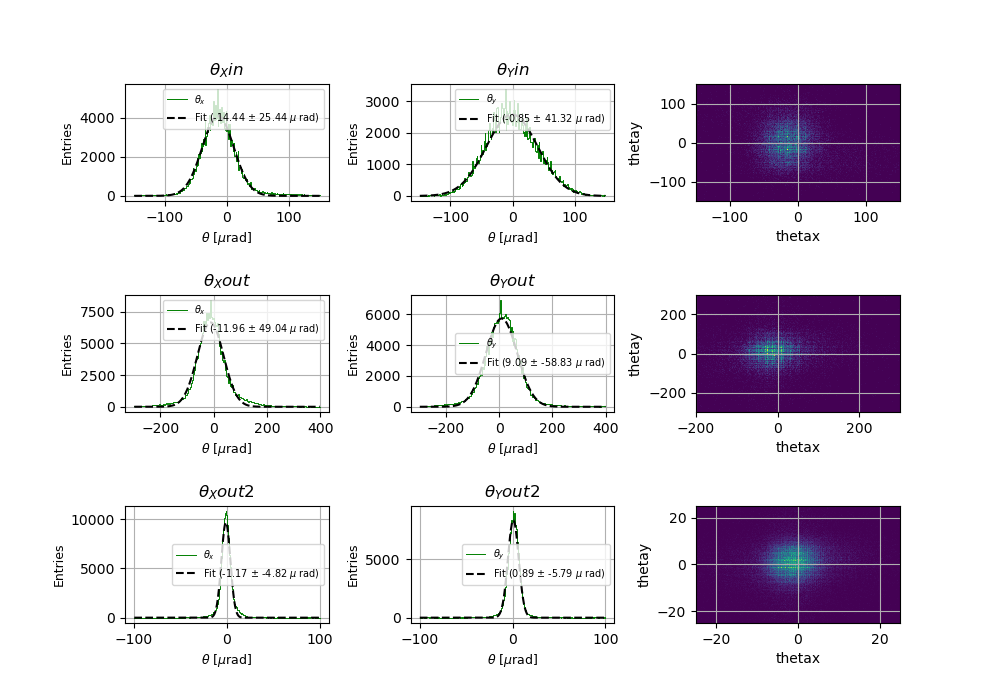

In [8]:
thetaLbl = ["x","y","_","x","y","_","x","y","_"]
num_bins = 500

fig, ax = plt.subplots(3,3)
fig.set_size_inches(10,7)
fig.subplots_adjust(wspace=.4,hspace=.8)
ax=ax.flatten()
print(ax.shape)
titles = [fr"$\theta_X in$ ", fr"$\theta_Y in $","_",fr"$\theta_X out $ ", fr"$\theta_Y out $","_",fr"$\theta_X out2 $ ", fr"$\theta_Y out2 $","_"]
fit_par=[]
for i in range(8):
    if i== 2 or i==5 or i==8:
        continue
    if i>=0 and i<2 :
        h, bins = np.histogram(thetain[i], bins = 300, range =[-150,150])
        binc = bins[:-1] + (bins[1] - bins[0]) / 2
        p0 = (np.max(h), binc[np.argmax(h)], np.std(thetain[i]))
    elif i>2 and i<=4:
        h, bins = np.histogram(thetaout[i-3], bins = 200,  range =[-300,400])
        binc = bins[:-1] + (bins[1] - bins[0]) / 2
        p0 = (np.max(h), binc[np.argmax(h)], np.std(thetaout[i-3]))
    elif i>4 :
        h, bins = np.histogram(thetaout2[i-6], bins = 400, range =[-100,100])
        binc = bins[:-1] + (bins[1] - bins[0]) / 2
        p0 = (np.max(h), binc[np.argmax(h)], np.std(thetaout2[i-6]))

    cond = h>0
    popt, pcov = curve_fit(myGauss, binc[cond], h[cond], sigma = np.sqrt(h[cond]), absolute_sigma = True, p0 = p0)
    fit_par.append(popt)

    ax[i].plot(binc, h, ds = "steps-mid", c = "green", lw = .7,
               label = fr"$\theta_{thetaLbl[i]}$")
    
    ax[i].plot(binc, myGauss(binc, *popt), ls = "--", c = "k", label = f"Fit ({popt[1]:.2f} $\pm$ {popt[2]:.2f} $\mu$ rad)")
    
    ax[i].grid()
    ax[i].set_title(titles[i])
    ax[i].set_ylabel("Entries", fontsize = 9)    
    ax[i].set_xlabel(r"$\theta$ [$\mu$rad]",fontsize = 9)
    
    ax[i].legend(fontsize = 7)
    
    print(f"La divergenza in {thetaLbl[i]} vale {popt[2]:.2f} \u03BCrad\n")


# PLOT hist2d
ax[2].hist2d(thetain[0], thetain[1], bins=num_bins, range=[[-150,150],[-150,150]])
ax[5].hist2d(thetaout[0], thetaout[1], bins=num_bins, range=[[-200,300],[-300,300]])
ax[8].hist2d(thetaout2[0], thetaout2[1], bins=int(num_bins*0.5), range=[[-25,25],[-25,25]] )

# Etichette degli assi
ax[2].grid()
ax[2].set_xlabel('thetax')
ax[2].set_ylabel('thetay')

ax[5].grid()
ax[5].set_xlabel('thetax')
ax[5].set_ylabel('thetay')

ax[8].grid()
ax[8].set_xlabel('thetax')
ax[8].set_ylabel('thetay')

plt.show()

#### Divergenza angolare in funzione della posizione in x del cristallo

In [9]:
    # Definizione delle posizioni
x_positions = xinfo[:,2]

x_val = (x_cry+x_positions/2*0.1) #fattore 2 serve per terere conto del fatto che l'unità di misura delle posizioni del goniometro è di 2mm
DelfX = theta_out_x - theta_in_x
DelfX2 = theta_out_x2 - theta_in_x  #tele3-BC2

In [10]:
div_ang_func_x = True if len(np.unique(xinfo[:,2]))>2 else False

if div_ang_func_x:
    # Scelta dei limiti per theta in
    th_in_cut_low = fit_par[0][1] - 5 #2.5
    th_in_cut_high = fit_par[0][1] + 5 #2.5
    #logi_th_in = (theta_in_x > th_in_cut_low) & (theta_in_x < th_in_cut_high)

    fig, ax = plt.subplots(2, sharex=True)
    fig.set_size_inches(12, 5)

    # Istogramma dei dati 
    hh = ax[0].hist2d(x_val, Dtheta, bins=[200, 500], range=[[np.min(x_val),np.max(x_val)],[-150,150]])#,norm=mpl.colors.LogNorm())
    #colorbar1 = fig.colorbar(hh[3], ax=ax[0])
    slices = hh[0]

    list_std=[np.std(slice) for slice in slices]
    ax[1].plot(hh[1][:-1], list_std)

    # fig.savefig(f'./img/Div{i}.png')
    # fig.savefig(f'./pdf/Div{i}.pdf')
    # plt.close(fig)

    plt.show()


In [71]:
###DEFINIZIONE DEL TAGLIO LOGICO SUL CRISTALLO
#logi_cry=(x_val>5.68) & (x_val<7.8)
logi_cry=(x_val>5.8) & (x_val<7.8)
th_in_cut_low = fit_par[0][1] -20#2.5
th_in_cut_high = fit_par[0][1] +20#2.5
logi_th_in = (theta_in_x > th_in_cut_low) & (theta_in_x < th_in_cut_high)


In [72]:
div_ang_func_xv2 = False #div_ang_func_x

#questo è un plot delle posizioni delle particelle interagenti con il detector 2 proiettate sul cristallo, plottate per i d
steps= np.unique(xinfo[:,2])
if div_ang_func_xv2:    

    for step in steps:
        #Scelta dei limiti per theta in 
        
        fig, ax = plt.subplots(3,1, sharex = True)
        fig.set_size_inches(7, 5)

        #definisco le posizioni
        Dtheta = theta_out_x-theta_in_x
        logi_Dtheta = (Dtheta > 0) & (Dtheta < 500) #taglio logico sui Dtheta, per ridurre i bin 
        #Istogrammo i dati
        x_positions=xinfo[:,2]
        hh = ax[0].hist2d(x_cry[(logi_th_in) & (logi_Dtheta) & (x_positions == step)]*100, Dtheta[(logi_th_in) & (logi_Dtheta) & (x_positions == step)], bins = [50,2000])# , norm = mpl.colors.LogNorm(), cmap = my_cmap)
        # print(np.shape(hh[0]))

        ax[0].set_ylim(200, 400)


        binc = hh[1][:-1] + (hh[1][1] - hh[1][0]) / 2

        # print(np.max(hh[0]))
        tresh = 0.01*np.max(hh[0])
        binary = hh[0]>tresh
        # print(np.shape(np.sum(binary,axis=1)))
        # ax[2].imshow((binary).T,origin="lower")

        ax[1].plot(binc,np.sum(binary,axis=1))
        
        #Tentativo di fare il profile
        X_prof, Y_prof ,sigma_Y = sb.hist2dToProfile(hh, "mean")
        ax[2].errorbar(X_prof,Y_prof,sigma_Y)
        ax[2].grid()

        for a in ax:
            a.set_xlabel('x scan [mm]')
            a.set_ylabel('defl X[$\mu$rad]')
            #a.set_xlim(0.9,1.35)
            #a.axvline(0.895, c = 'hotpink')
            #a.axvline(x_cut_low, c = 'hotpink')
            #a.axvline(x_cut_high, c = 'hotpink')
        fig.colorbar(hh[3], ax = ax[0])
        #fig.savefig(f'./img/Div{i}.png')
        #fig.savefig(f'./pdf/Div{i}.pdf')
        #plt.close(fig)
    plt.show()

#### Bruco plot

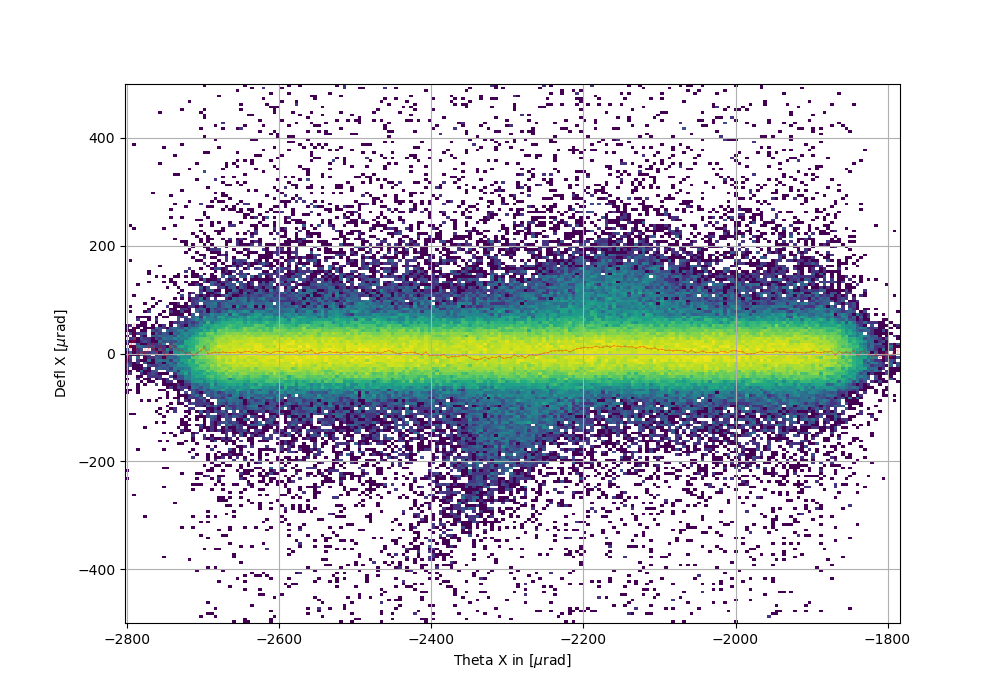

In [76]:

Brucoplot = True if len(np.unique(xinfo[:,0]))>1 else False

if Brucoplot:
    
    deflX = theta_out_x-theta_in_x
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 7)
    rot = xinfo[:,0]
    #fig.suptitle(f'Bruco Plot [{x_cut_low:.4f}_{x_cut_high:.4f} um]', fontsize = 20)
    bin_step = 2 #urad
    # hh = ax.hist2d((rot+theta_in_x)[logi_pos],(deflX)[logi_pos], bins = [np.arange(min((rot+theta_in_x)[logi_pos]),max((rot+theta_in_x)[logi_pos]),bin_step),400],  cmap = my_cmap, norm = mpl.colors.LogNorm()) 
    hh = ax.hist2d((rot-theta_in_x)[logi_cry],(deflX)[logi_cry], 
                    bins = [len(np.unique(xinfo[:,0]))*5, 200],
                    cmap = "viridis",
                    range = [[min(rot)-100,max(rot)+100],[-500,500]],
                    norm=mpl.colors.LogNorm())

    X_prof, Y_prof, sigma_Y = sb.hist2dToProfile(hh, "mean")
    ax.errorbar(X_prof, Y_prof, sigma_Y, color = "red", lw =0.2)
    ax.grid()
    # hh = ax.hist2d((rot+theta_in_x)[logi_pos],(deflX)[logi_pos], bins = [500,400],  cmap = my_cmap, norm = mpl.colors.LogNorm()) 
    # hh = ax.hist2d((rot+theta_in_x)[logi_pippo], (deflX)[logi_pippo], bins = [np.arange(min((rot+theta_in_x)[logi_pippo]),max((rot+theta_in_x)[logi_pippo]),5),400],  cmap = my_cmap, norm = mpl.colors.LogNorm()) 


    # ax.set_xlim(np.min(hh[1][(hh[0]>100).any(axis=1)]),np.max(hh[1][(hh[0]>100).any(axis=1)]))
    #x_lim=(-50835,-50750)
    #ax.set_ylim(-100, 100)
    #ax.set_xlim(x_lim)
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(30))  # Imposta il tick ogni 100 valori
    #channeling cut selection

    #print (f'{i} {x_cut_low:.4f} Defl X {abs(def_high - def_low):.2f} urad')

    #ax.axvline(x_div_low, c = 'white')
    #ax.axvline(x_div_high, c = 'white')

    #ax.axhline(def_low, c = 'white')
    #ax.axhline(def_high, c = 'white')

    ax.set_xlabel('Theta X in [$\mu$rad]')
    ax.set_ylabel('Defl X [$\mu$rad]')


    #fig.colorbar(hh[3], ax = ax)
    # fig.savefig(f'./img/Bruco{i}.png')
    #fig.savefig(f'./pdf/Bruco{i}.pdf')
    #plt.close(fig)
    plt.show()

In [75]:
singleDAQ = not(Brucoplot or div_ang_func_x) #NOR LOGIC

if singleDAQ:
    # plt.ioff()
    # logi_pippo = (logi_pos) & (logi_th_in)
    deflX = theta_out_x-theta_in_x
    x_cut_low = 1.05
    x_cut_high = x_cut_low + 0.350
    logi_pos = (x_cry > x_cut_low) & (x_cry < x_cut_high)  

    fig, ax = plt.subplots(2, 1)
    fig.set_size_inches(10, 7)
    rot = xinfo[:,0]
    #fig.suptitle(f'Bruco Plot [{x_cut_low:.4f}_{x_cut_high:.4f} um]', fontsize = 20)
    bin_step = 2 #urad
    # hh = ax.hist2d((rot+theta_in_x)[logi_pos],(deflX)[logi_pos], bins = [np.arange(min((rot+theta_in_x)[logi_pos]),max((rot+theta_in_x)[logi_pos]),bin_step),400],  cmap = my_cmap, norm = mpl.colors.LogNorm()) 
    hh = ax[0].hist2d((rot+theta_in_x)[logi_pos],(deflX)[logi_pos], 
                    bins = [len(np.unique(xinfo[:,0]))*200, 500],
                    cmap = "viridis",
                    range = [[min(rot)-100,max(rot)+100],[-500,1100]],
                    norm=mpl.colors.LogNorm())

    X_prof, Y_prof, sigma_Y = sb.hist2dToProfile(hh, "mean")
    ax[0].errorbar(X_prof, Y_prof, sigma_Y, color = "red", lw =0.1)
    ax[0].grid()
    # hh = ax.hist2d((rot+theta_in_x)[logi_pos],(deflX)[logi_pos], bins = [500,400],  cmap = my_cmap, norm = mpl.colors.LogNorm()) 
    # hh = ax.hist2d((rot+theta_in_x)[logi_pippo], (deflX)[logi_pippo], bins = [np.arange(min((rot+theta_in_x)[logi_pippo]),max((rot+theta_in_x)[logi_pippo]),5),400],  cmap = my_cmap, norm = mpl.colors.LogNorm()) 
    h, bins = np.histogram(deflX[logi_pos], bins = 500, range=[0,600])
    binc = bins[:-1] + (bins[1] - bins[0]) / 2
    ax[1].plot(binc, h, ds = "steps-mid", c = "green", lw = .7)
    ax[1].grid()
    # ax.set_xlim(np.min(hh[1][(hh[0]>100).any(axis=1)]),np.max(hh[1][(hh[0]>100).any(axis=1)]))
    #x_lim=(-50835,-50750)
    #ax.set_ylim(-100, 100)
    #ax.set_xlim(x_lim)
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(30))  # Imposta il tick ogni 100 valori
    #channeling cut selection

    #print (f'{i} {x_cut_low:.4f} Defl X {abs(def_high - def_low):.2f} urad')

    #ax.axvline(x_div_low, c = 'white')
    #ax.axvline(x_div_high, c = 'white')

    #ax.axhline(def_low, c = 'white')
    #ax.axhline(def_high, c = 'white')

    ax[0].set_xlabel('Theta X in [$\mu$rad]')
    ax[0].set_ylabel('Defl X [$\mu$rad]')
    ax[1].set_ylabel('Theta X in [$\mu$rad]')


    fig.colorbar(hh[3], ax = ax[0])
    # fig.savefig(f'./img/Bruco{i}.png')
    #fig.savefig(f'./pdf/Bruco{i}.pdf')
    #plt.close(fig)
    plt.show()